In [1]:
import torch
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import copy
import random
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
class DataLoader():
    def __init__(self,training_path,batch_size):
        self.Dict, self.Lookup=self.Mapping()
        self.raw,self.tags,self.max_length=self.Load(training_path)
        self.idx_size=30
        self.data_length=len(self.raw)
        #self.train_dataset=self.BuildTrainingDataset(batch_size);
        

        
    def Mapping(self):
        dict={'start':0,'end':1,'padding':2,'unknown':3}
        lookup={0:'start',1:'end',2:'padding',3:'unknown'}
        offset=len(dict)
        
        for i in range(26):
            dict[chr(ord('a')+i)]=i+offset
            lookup[i+offset]=chr(ord('a')+i)
        
        return dict,lookup
    
    
    def Word2Idx(self,word):
        idx_sequence=[self.Dict['start']]
        
        for char in word:
            idx_sequence.append((self.Dict[char] if char in self.Dict else self.Dict['unknow']))
        
        idx_sequence.append(self.Dict['end'])
        
        return idx_sequence
    
    def Idx2Word(self,idx):
        word=""
        for i in idx:
            if i==self.Dict['start'] or i==self.Dict['end'] or i==self.Dict['padding']:
                continue;
            else:
                word+=(self.Lookup[i] if i!=self.Dict['unknown'] else '?')
        return word
    
    def Load(self,path):
        raw=[]
        tags=[]
        max_length=0
        with open(path,'r') as file:
            for data in file:
                words=data.split()
                for i in range(4):
                    raw.append(words[i])
                    tags.append(i)
                    if len(words[i])>max_length:
                        max_length=len(words[i])
        return raw,tags,max_length
    
    def BuildTrainingDataset(self,batch_size,shuffle=True):
        
        idx=[i for i in range(self.data_length)]
        
        if shuffle:
            np.random.shuffle(idx)
        
        raw_idx=[self.Word2Idx(w) for w in self.raw]
                
        rawTrain=[(raw_idx[i],self.tags[i]) for i in idx]
        
        rawBatch=[
            rawTrain[k:k+batch_size]
            for k in range(0,self.data_length,batch_size)
        ]
        
      
        
        trainDataset=[]
        for batch in rawBatch:
            data=[b[0] for b in batch]
            tags=[b[1] for b in batch]
            data = sorted(data, key=lambda x: len(x), reverse=True)  # sorted by input_lengths
            maxLength=len(data[0])
            
            
            lengths=[len(d) for d in data]
            
            
            for idx,d in enumerate(data):
                for i in range(maxLength-len(d)):
                    data[idx].append(self.Dict['padding'])
         
            inputs_val=copy.copy(data)
            inputs_length=copy.copy(lengths)
            targets_val=copy.copy(data)
            targets_length=copy.copy(lengths)
            
            inputs_val = Variable(torch.LongTensor(inputs_val)).transpose(0, 1).cuda()  
            targets_val = Variable(torch.LongTensor(targets_val)).transpose(0, 1).cuda()
            tags=Variable(torch.LongTensor(tags)).cuda()
            trainDataset.append(((inputs_val,inputs_length), (targets_val,targets_length),tags))
            
            yield (inputs_val,inputs_length), (targets_val,targets_length),tags
               
      
        return trainDataset


In [17]:
class RnnEncoder(nn.Module):
    def __init__(self,idx_size,embedding_size,output_size,condition_size):
        super(RnnEncoder, self).__init__()
        
        self.hidden_size=output_size
        self.embedding=nn.Embedding(idx_size,embedding_size)
        self.gru=nn.GRU(embedding_size,output_size+condition_size)
    
    def forward(self,inputs,length,hidden=None):
        embedded=self.embedding(inputs)
        packed=pack_padded_sequence(embedded,length)
        packed_outputs,hidden=self.gru(packed,hidden)
        outputs,output_length=pad_packed_sequence(packed_outputs)
        return outputs,hidden
    
    def initHidden(self,batch_size):
        return torch.zeros(1, batch_size, self.hidden_size).cuda()
    
class RnnDecoder(nn.Module):
    def __init__(self,idx_size,embedding_size,hidden_size,start_idx,max_length,teacher_forcing_ratio,condition_size):
        super(RnnDecoder,self).__init__()
        
        self.embedding=nn.Embedding(idx_size,embedding_size)
        self.gru=nn.GRU(embedding_size,hidden_size+condition_size)
        self.out = nn.Linear(hidden_size+condition_size, idx_size)
        self.log_softmax = nn.LogSoftmax()
        
        self.embedding_size=embedding_size
        self.conditions_size=condition_size
        self.hidden_size=hidden_size
        self.output_size=idx_size
        self.start_idx=start_idx
        self.max_length=max_length
        self.teacher_forcing_ratio=teacher_forcing_ratio
    
    def forward(self,latent_vector,targets):
        
        target_val, target_lengths = targets
        batch_size = latent_vector.size(1)
        
        inputs = Variable(torch.LongTensor([[self.start_idx] * batch_size])).cuda()
        hidden=latent_vector
        
        max_target_length = max(target_lengths)
        outputs = Variable(torch.zeros(
            max_target_length,
            batch_size,
            self.output_size
        )).cuda() 
        
        use_teacher_forcing = True if random.random() > self.teacher_forcing_ratio else False
        
        for t in range(max_target_length):
            outputs_on_t, hidden = self.forward_step(inputs,hidden)
            outputs[t] = outputs_on_t
            if use_teacher_forcing:
                input = target_val[t].unsqueeze(0)
            else:
                input = self.Decode2Idx(outputs_on_t)

        return outputs, hidden
    
    
    def forward_step(self, inputs, hidden):
     
        batch_size = inputs.size(1)
        embedded = self.embedding(inputs)
        embedded.view(1, batch_size, self.embedding_size) 
        output, hidden = self.gru(embedded, hidden)  
        

        output = output.squeeze(0) 
        output = self.log_softmax(self.out(output)) 
        return output, hidden
    
    def evaluation(self, latent_vector):
        
        batch_size = latent_vector.size(1)
        inputs = Variable(torch.LongTensor([[self.start_idx] * batch_size])).cuda()
        hidden = latent_vector

        outputs = Variable(torch.zeros(
            self.max_length,
            batch_size,
            self.output_size
        )).cuda()

   

       
        for t in range(self.max_length):
            outputs_on_t, hidden = self.forward_step(inputs, hidden)
            outputs[t] = outputs_on_t
            input = self.Decode2Idx(outputs_on_t)  

        return self.Decode2Idxs(outputs)
    
    def Decode2Idx(self, output):
        value, index = torch.topk(output, 1)
        index = index.transpose(0, 1) 
        index.cuda()
        return index

    def Decode2Idxs(self, outputs):
        indices = []
        batch_size = outputs.size(1)
        outputs = outputs.transpose(0, 1) 

        for b in range(batch_size):
            top_ids = self.Decode2Idx(outputs[b])
            indices.append(top_ids.data[0])
        return indices

    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder,hidden_size,condition_idx,condition_size,latent_size,batch_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        self.batch_size=batch_size
        self.embedding=nn.Embedding(condition_idx,condition_size)
        self.hidden2mean=nn.Linear(hidden_size+condition_size,latent_size)
        self.hidden2logv=nn.Linear(hidden_size+condition_size,latent_size)
        self.latent2hidden=nn.Linear(latent_size,hidden_size)
        
        
    def forward(self, inputs, targets,conditions):
        
        input_vals, input_lengths = inputs
        c=self.embedding(conditions)
        c=c.view(1,self.batch_size,-1)
        cz=copy.copy(c)
        initHidden=self.encoder.initHidden(batch_size)
        
        hidden=torch.cat((initHidden,c),2)
       
        encoder_outputs, encoder_hidden = self.encoder.forward(input_vals, input_lengths,hidden)
                
        mu=self.hidden2mean(encoder_hidden)
        logvar=self.hidden2logv(encoder_hidden)
        
        z=self.reparameterize(mu,logvar)       
        z=self.latent2hidden(z)
        
        z=torch.cat((z,cz),2)
        
        decoder_outputs, decoder_hidden = self.decoder.forward(z, targets)      
        return decoder_outputs, decoder_hidden,logvar,mu

    def evaluation(self, inputs,conditions,conditions1):
        input_vars, input_lengths = inputs
        c=self.embedding(conditions)
        c=c.view(1,self.batch_size,-1)
        
        c1=self.embedding(conditions1)
        c1=c1.view(1,self.batch_size,-1)
        
        
        initHidden=self.encoder.initHidden(batch_size)
        
        hidden=torch.cat((initHidden,c),2)
    
        
        encoder_outputs, encoder_hidden = self.encoder(input_vars, input_lengths,hidden)
        
        mu=self.hidden2mean(encoder_hidden)
        logvar=self.hidden2logv(encoder_hidden)
        z=self.reparameterize(mu,logvar)
       
        z=self.latent2hidden(z)
        
        z=torch.cat((z,c1),2)
        
        decoded_output = self.decoder.evaluation(z)
        return decoded_output
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar).cuda()
        eps = Variable(torch.randn_like(std).cuda())
        return mu + eps*std


In [18]:
def loss_fn(outputs,targets,log_var,mu,loss_func):
    reconstruct_loss=loss_func(outputs,targets)
    KL_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return reconstruct_loss,KL_loss

In [25]:
batch_size=16
data=DataLoader('./data/train.txt',batch_size)

embedding_size=64
hidden_size=256
latent_size=32
condition_idx=4
condition_size=8
teacher_forcing_ratio=0.5
learning_rate=0.05
epochs=50
beta=0
period=4000

Encoder=RnnEncoder(idx_size=data.idx_size,
                   embedding_size=embedding_size,
                   output_size=hidden_size,
                   condition_size=condition_size).cuda()


Decoder=RnnDecoder(idx_size=data.idx_size,
                   embedding_size=embedding_size,
                   hidden_size=hidden_size,
                   start_idx=data.Dict['start'],
                   max_length=data.max_length,
                   teacher_forcing_ratio=teacher_forcing_ratio,
                   condition_size=condition_size).cuda()


seq2seq=Seq2Seq(encoder=Encoder,
                decoder=Decoder,
                hidden_size=hidden_size,
                condition_idx=condition_idx,
                condition_size=condition_size,
                latent_size=latent_size,
                batch_size=batch_size).cuda()

In [26]:
model=seq2seq
model.train()
loss_func=nn.NLLLoss(ignore_index=data.Dict['padding'], size_average=True)
optimizer=optim.SGD(model.parameters(),lr=learning_rate)

re_loss=[]
kl_loss=[]
step = 0
for epoch in range(epochs):
    mini_batches = data.BuildTrainingDataset(batch_size)
    for inputs,targets,conditions in  mini_batches:
        
        
        if(inputs[0].shape[1]!=batch_size):
            continue
        
        optimizer.zero_grad()
    
        
        outputs,hidden,log_var,mu=model(inputs,targets,conditions)
        
        b = outputs.size(1)
        t = outputs.size(0)
        targets = targets[0].contiguous().view(-1) 
        outputs = outputs.view(b * t, -1)  
     
        
        #KL_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
        
        NLL_loss, KL_loss=loss_fn(outputs,targets,log_var,mu,loss_func)
        loss = (NLL_loss + beta * KL_loss)
        
        
        
        
        
        
        
        #beta=min(1,beta+1/period)
        step += 1
        
        
        if(step%(period*2)==0):
            beta=0
        
        
        loss.backward()
        optimizer.step()
    re_loss.append(NLL_loss)
    kl_loss.append(KL_loss)
    print(beta)
    print("epoch:", epoch, "loss of char: ", loss.data)
    #print(KL_loss)

C:\Users\ec131b\Anaconda3\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
C:\Users\ec131b\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0
epoch: 0 loss of char:  tensor(2.4641, device='cuda:0')
0
epoch: 1 loss of char:  tensor(2.4029, device='cuda:0')
0
epoch: 2 loss of char:  tensor(2.2927, device='cuda:0')
0
epoch: 3 loss of char:  tensor(2.3781, device='cuda:0')
0
epoch: 4 loss of char:  tensor(2.3653, device='cuda:0')
0
epoch: 5 loss of char:  tensor(2.3526, device='cuda:0')
0
epoch: 6 loss of char:  tensor(2.3861, device='cuda:0')
0
epoch: 7 loss of char:  tensor(2.2493, device='cuda:0')
0
epoch: 8 loss of char:  tensor(2.2335, device='cuda:0')
0
epoch: 9 loss of char:  tensor(2.0841, device='cuda:0')
0
epoch: 10 loss of char:  tensor(2.0326, device='cuda:0')
0
epoch: 11 loss of char:  tensor(2.0049, device='cuda:0')
0
epoch: 12 loss of char:  tensor(2.1967, device='cuda:0')
0
epoch: 13 loss of char:  tensor(2.2063, device='cuda:0')
0
epoch: 14 loss of char:  tensor(1.9507, device='cuda:0')
0
epoch: 15 loss of char:  tensor(2.0354, device='cuda:0')
0
epoch: 16 loss of char:  tensor(1.8590, device='cuda:0')
0
epoch

In [27]:
model.eval()
for epoch in range(1):
    mini_batches = data.BuildTrainingDataset(16)
    for inputs,targets,conditions in  mini_batches:
        for i in inputs[0].transpose(0, 1):
            w=data.Idx2Word(i.cpu().numpy())
            print(w)
        print(conditions)
        condition1=(conditions+1)%4
        print("-----------------")
        decoded_indices=model.evaluation(inputs,conditions,conditions)
        for i in decoded_indices:
            w=data.Idx2Word(i.cpu().numpy())
            print(w)
        
        ##results.append(data.Idx2Word(indices.cpu()))
        break
        
      


fictionalizing
participates
committing
enlighten
revealing
adjoining
fumbles
spurred
pursues
scrape
belies
hoped
balks
crash
hears
stole
tensor([0, 3, 2, 1, 0, 2, 0, 1, 1, 3, 1, 2, 3, 1, 2, 1], device='cuda:0')
-----------------


C:\Users\ec131b\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


fictiiaaizing
partiiaates
committng
enllitteh
revealing
adjonning
fumbles
spurred
pursues
scrape
belies
poped
balks
crash
hears
stole


In [28]:
import matplotlib.pyplot as plt

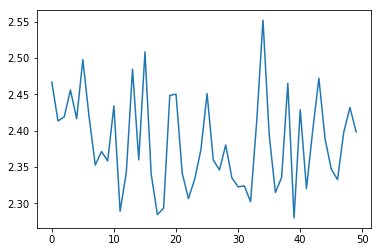

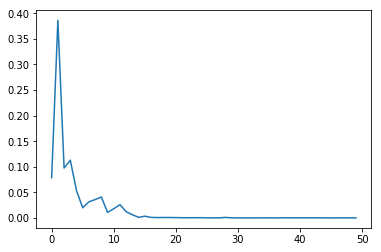

In [24]:
plt.plot(re_loss)
plt.show()
plt.plot(kl_loss)
plt.show()

In [ ]:
print(indices.data.cpu())

In [ ]:
print